## 1, ライブラリをインポート

In [263]:
import os, io, re
import cv2
import glob
import pickle
import shap
import optuna
import lightgbm as lgb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [264]:
from PIL import Image
from functools import partial
from pycm import ConfusionMatrix

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import random_rotation, random_shift, random_zoom

In [265]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1815249656874902825,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4937233203
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2699128164499525852
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## 2, 学習データを前処理

In [266]:
for i,file in enumerate(os.listdir("./csv/")):
    if i == 0:
        df = pd.read_csv("./csv/" + file, encoding="SJIS")
    else:
        df = pd.concat([df,pd.read_csv("./csv/" +file, encoding="SJIS")])
        
df.columns = ["image","front","close","background","focus","cute","position","brightness","plural","care"]
df = df.reset_index(drop=True)
df["image"] = [("00000" + i) for i in df["image"]]
df

,image,front,close,background,focus,cute,position,brightness,plural,care
0,00000025_018.jpg,5,5,5,4,2,4,2,0,0
1,00000025_022.jpg,5,4,3,4,3,4,2,0,0
2,00000025_029.jpg,3,3,3,5,4,3,2,0,1
3,00000026_001.jpg,5,3,2,4,4,3,3,0,1
4,00000026_008.jpg,5,3,4,5,3,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...
695,00000011_025.jpg,4,3,4,5,4,3,3,2,0
696,00000011_027.jpg,5,4,2,4,4,3,3,0,0
697,00000012_010.jpg,5,3,5,5,5,3,3,0,1
698,00000012_022.jpg,3,3,4,3,3,4,3,0,0


Data must have variance to compute a kernel density estimate.


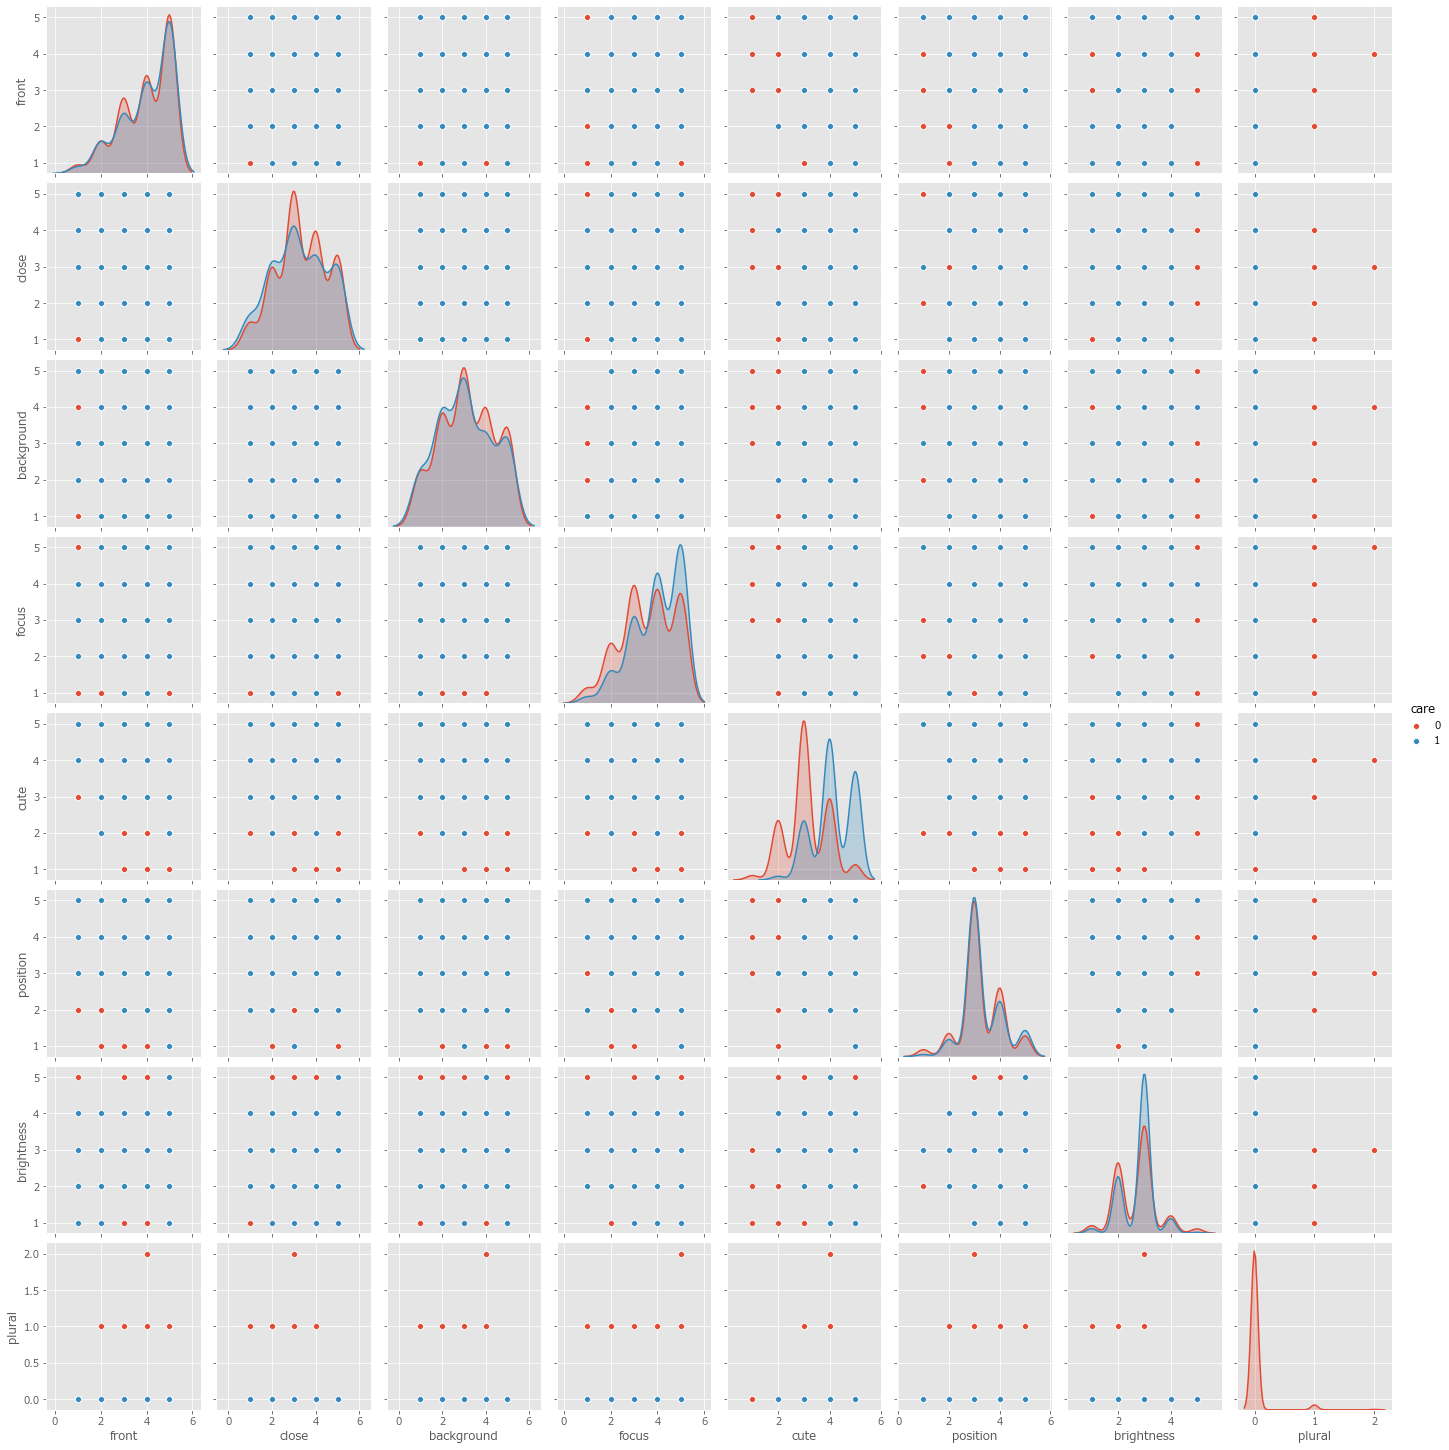

In [267]:
#離散なのに散布図です・・・欲しいのは対角線に表示されている確率密度です。
g = sns.pairplot(df.drop("image",axis=1),hue="care")
g.fig.set_figheight(20)
g.fig.set_figwidth(20)

In [268]:
#水増しフラグ
padding_flag = True

In [269]:
image_size=80
X=[]

for image_path in df["image"]:
    #画像ファイル取得
    img_file = glob.glob("./image/" + image_path)
    if not img_file:
        print(image_path)
        continue
    image = Image.open(img_file[0])
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    X.append(np.array(image))
    
del image

## 3, 小モデル作成

In [270]:
def create_model1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 5, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size = 4, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

In [271]:
def create_model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 4, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [272]:
def column_predict(X_train,X_valid,y_train,y_valid,column):
    
    sess = tf.InteractiveSession()
    
    model = create_model1()
    callbacks = [ReduceLROnPlateau(monitor='loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='loss', patience=10)]
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    model.summary()
    
    hist = model.fit(X_train, y_train, epochs=100, batch_size=20,verbose=0,callbacks=callbacks)
    pickle.dump(model,open("model/model_" + str(column) + ".sav","wb"))
    
    pred = model.predict(X_valid)
    MSE_pred = mean_squared_error(pred, y_valid)

    mean_pred = np.full(len(y_valid), y_train.mean())
    MSE_mean = mean_squared_error(mean_pred, y_valid)
    
    fig = plt.figure(figsize=(12, 16))
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(column, fontsize=20)
    
    ax1 = fig.add_subplot(211,
                          title="Loss",
                          ylabel="Loss",
                          xlabel="Epoch")
    ax1.plot(hist.history["loss"])
    ax1.legend(["Train", "Test"], loc="upper left")

    ax2 = fig.add_subplot(212,
                          title="pred(mse):" + str(MSE_pred)[:5] + "\n" +"baseline(mse):" + str(MSE_mean)[:5],
                          ylabel="Score",
                          xlabel="ID")
    ax2.plot(y_valid, label="Actual")
    ax2.plot(pred, label="Pred")
    ax2.plot(mean_pred, label="Mean")
    ax2.legend(loc="upper right")
    
    plt.show()

    
    with tf.Session() as sess:
         sess.run(tf.global_variables_initializer())
    
    explainer = shap.DeepExplainer(model, (X_train[0:200]*255))
    for i in range(3):
        index_names = np.array("True:" + str(y_valid[i]) + "\n" + "Pred:" + str(pred[i][0])[:4]).reshape(1,1)
        shap_values = explainer.shap_values(X_valid[[i]]*255)
        shap.image_plot(shap_values, X_valid[[i]], index_names)
        plt.gcf().set_size_inches(20, 20)
    
    return(pred)
    

In [273]:
X = np.array(X)
Y = np.array(df[["front","close","background","focus","cute","position","brightness","plural","care"]])

X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 1,test_size = 0.1)

y_train,care_train = np.hsplit(y_train, [len(y_train[0])-1])
y_valid,care_valid = np.hsplit(y_valid, [len(y_valid[0])-1])

In [274]:
#レーダーチャート関数
def plot_polar(labels, values, values2 = np.array([])):
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
    values = np.concatenate((values, [values[0]]))  # 閉じた多角形にする
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', label="True")  # 外枠
    if len(values2) != 0:
        values2 = np.concatenate((values2, [values2[0]]))  # 閉じた多角形にする
        ax.plot(angles, values2, 'o-', label="Pred")
        ax.legend(loc=(0.01, 0.01))
    ax.fill(angles, values, alpha=0.25)  # 塗りつぶし
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)  # 軸ラベル
    ax.set_rlim(0 ,5)
    plt.show()

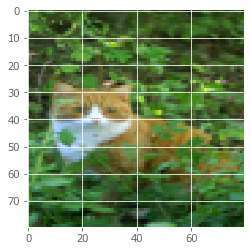

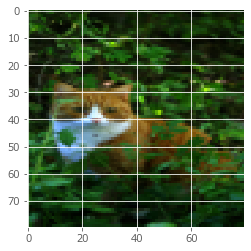

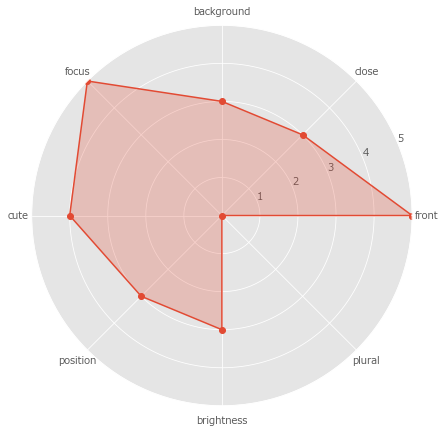

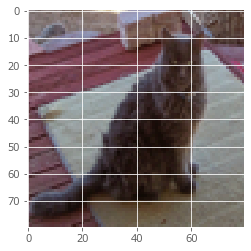

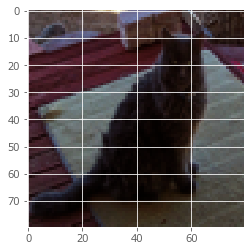

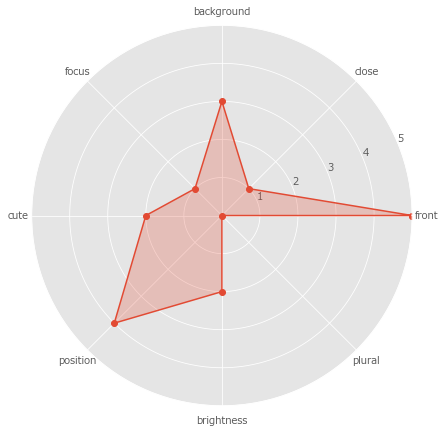

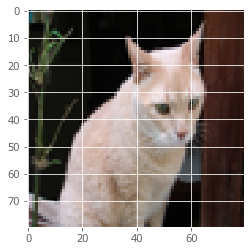

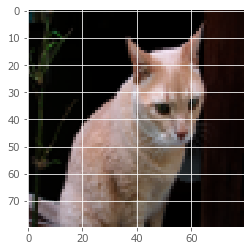

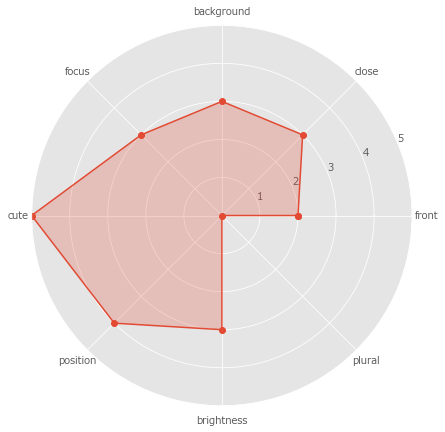

In [275]:
if padding_flag:
    #水増し(回転)を入れる予定
    #水増し(ガンマ変換)
    X_train = list(X_train)
    
    gamma = 0.6
    look_up_table = np.ones((256, 1), dtype = 'uint8' ) * 0
    for i in range(256):
        look_up_table[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)
    X_temp = []
    for i in range(len(X_train)):
        img = np.array(X_train[i]).transpose(1, 2, 0)
        img_gamma = cv2.LUT(img, look_up_table)
        X_temp.append(list(img_gamma.transpose(2,0,1)))

    X_temp = np.array(X_temp)
    X_train = np.vstack((X_train,X_temp))
    y_train = np.append(y_train,y_train,axis=0)
    
    #スコア、解像度、ガンマ変換を確認
    for i in range(3):
        plt.imshow(X_train[i])
        plt.show()
        
        plt.imshow(X_train[i + int(len(X_train)/2)])
        plt.show()
        
        plot_polar(["front","close","background","focus","cute","position","brightness","plural"], y_train[i])
        
        
X_train = X_train.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_52 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 7, 7, 64)          0         
__________

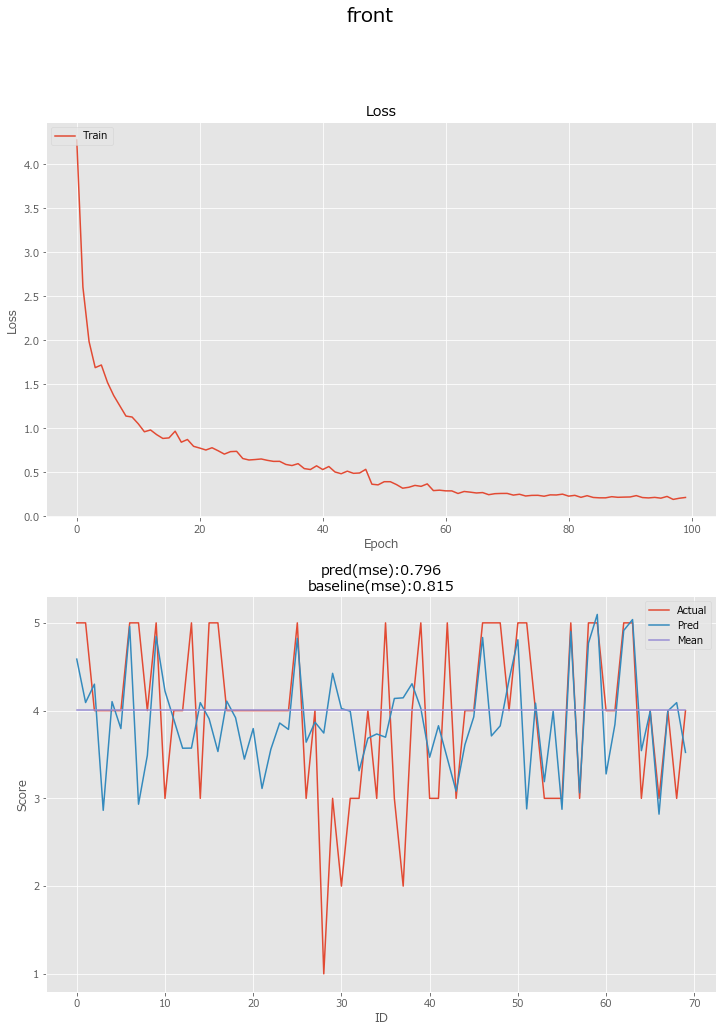

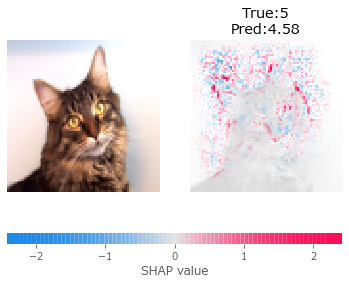

<Figure size 1440x1440 with 0 Axes>

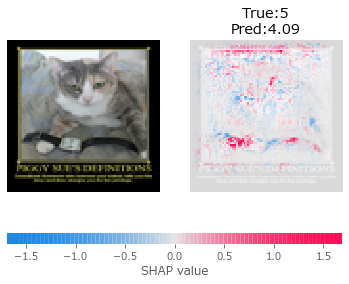

<Figure size 1440x1440 with 0 Axes>

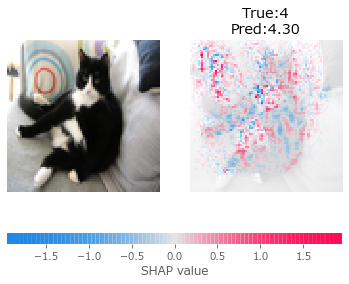

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_53 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

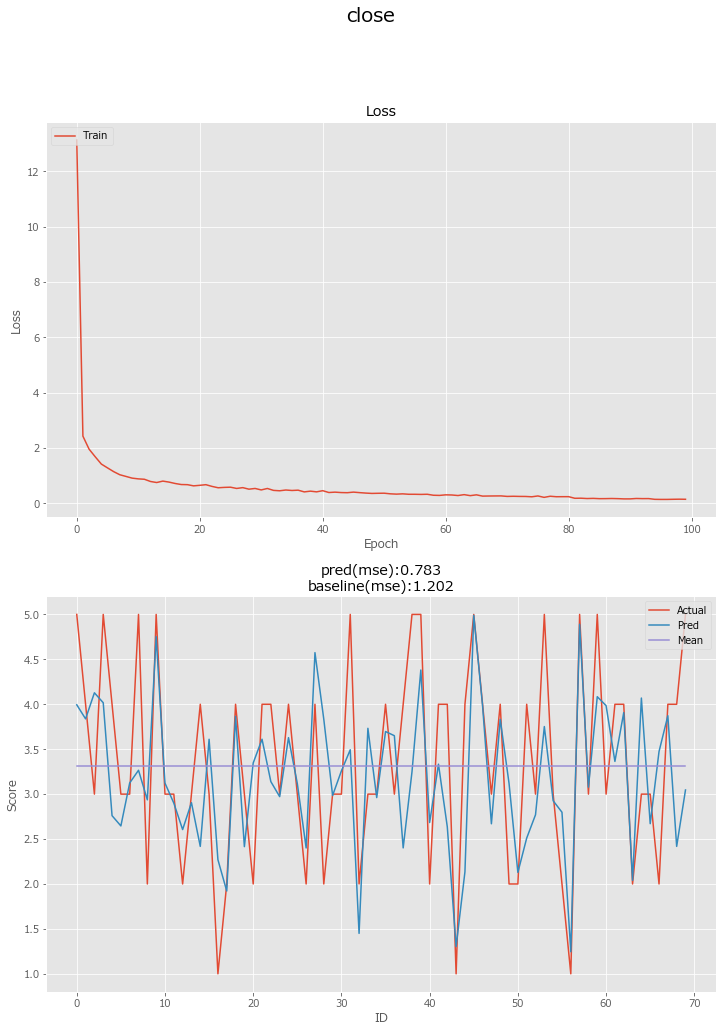

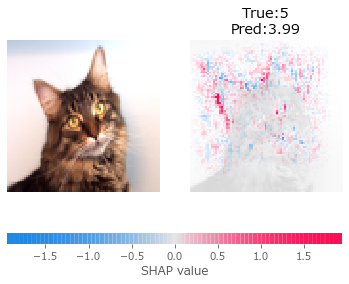

<Figure size 1440x1440 with 0 Axes>

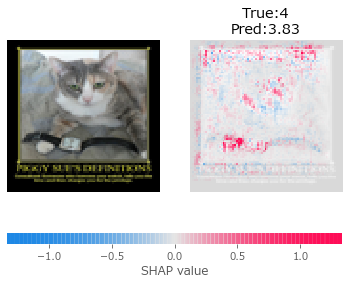

<Figure size 1440x1440 with 0 Axes>

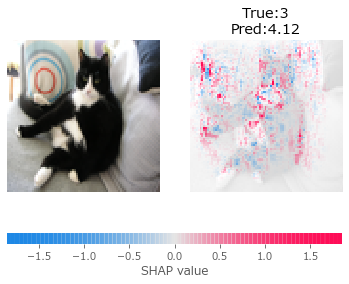

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_54 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

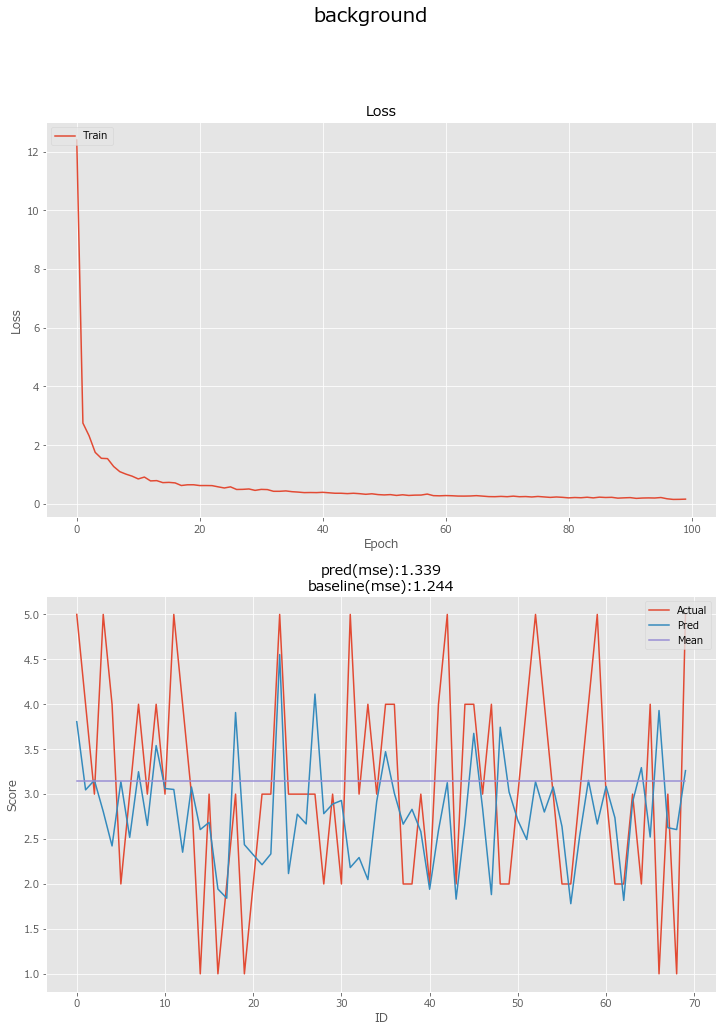

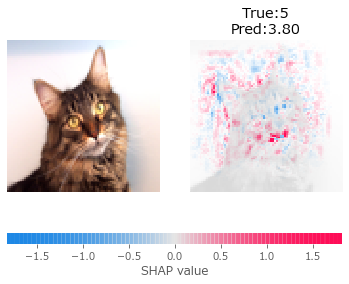

<Figure size 1440x1440 with 0 Axes>

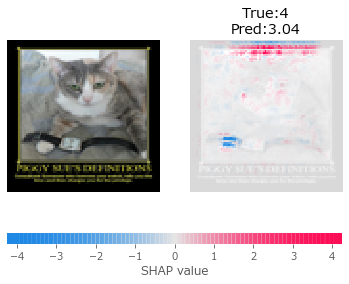

<Figure size 1440x1440 with 0 Axes>

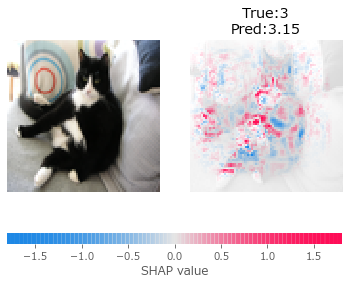

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_55 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

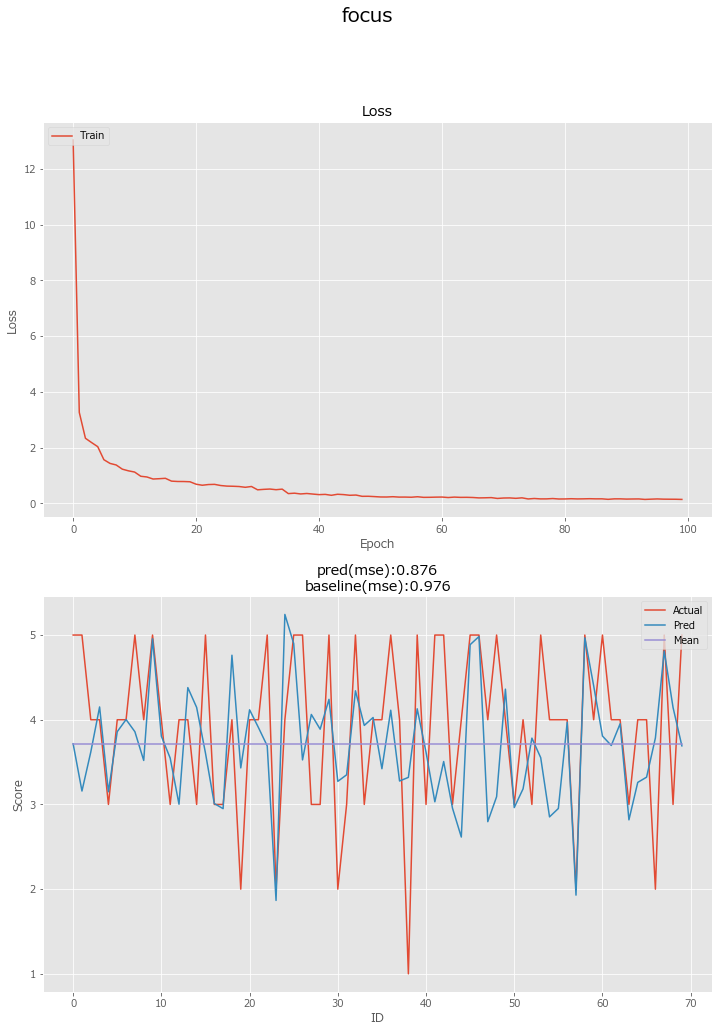

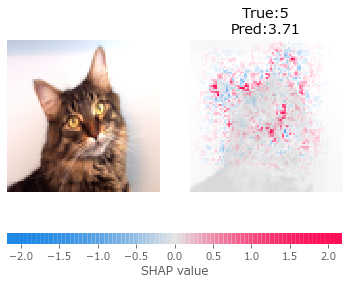

<Figure size 1440x1440 with 0 Axes>

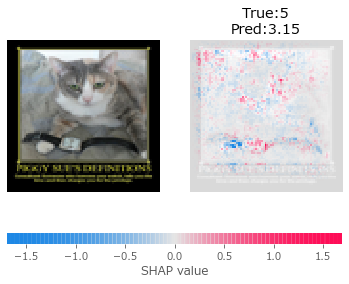

<Figure size 1440x1440 with 0 Axes>

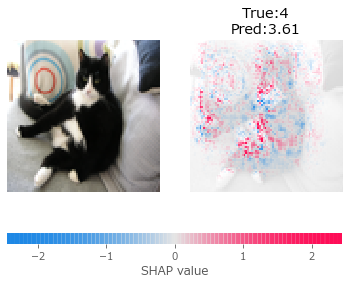

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_56 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

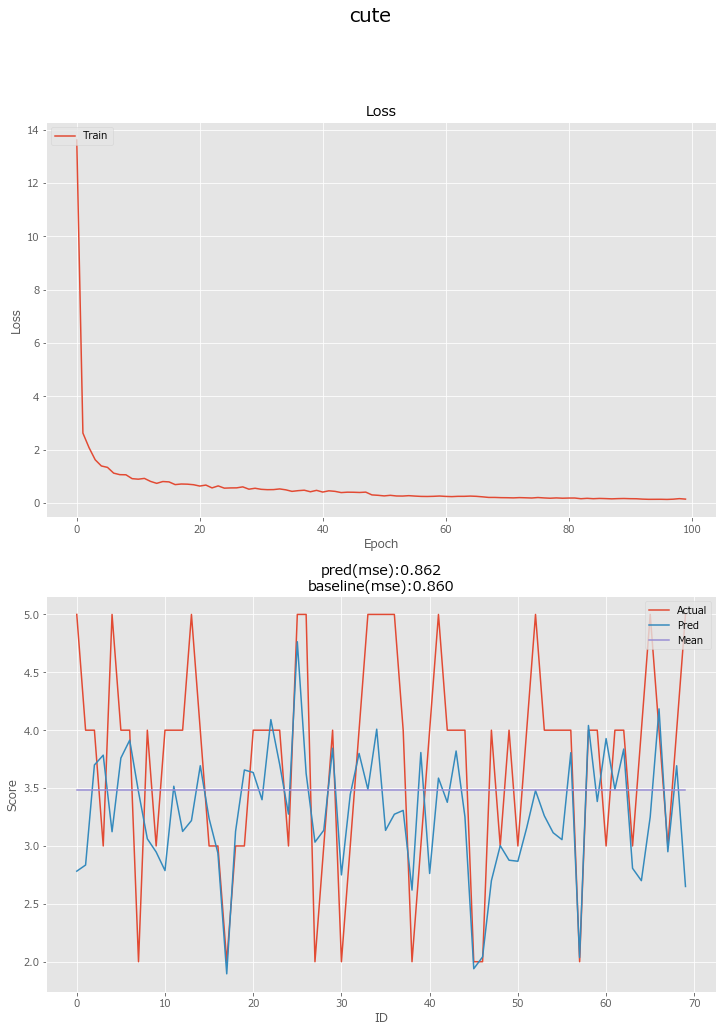

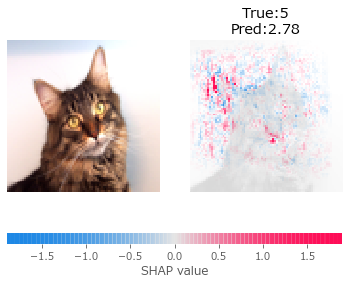

<Figure size 1440x1440 with 0 Axes>

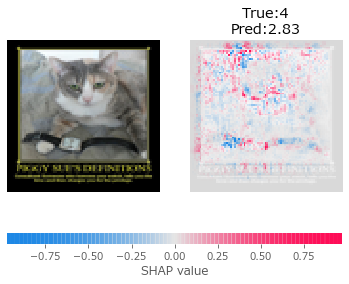

<Figure size 1440x1440 with 0 Axes>

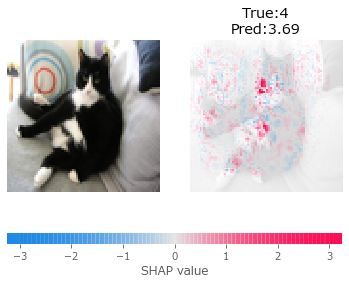

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_57 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

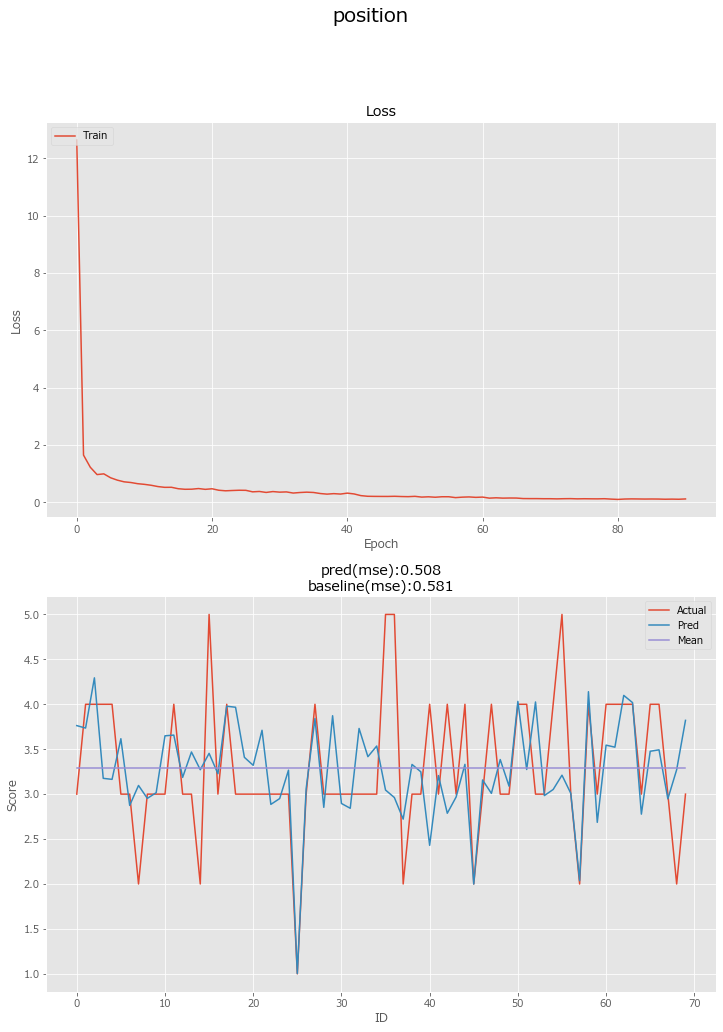

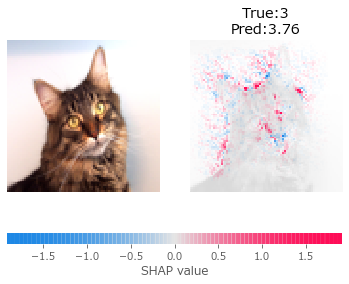

<Figure size 1440x1440 with 0 Axes>

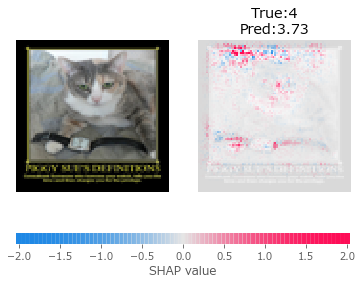

<Figure size 1440x1440 with 0 Axes>

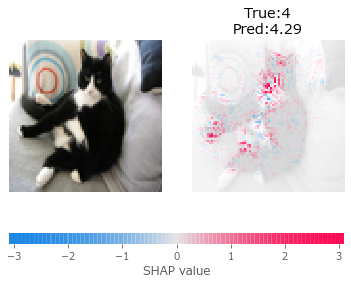

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_58 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

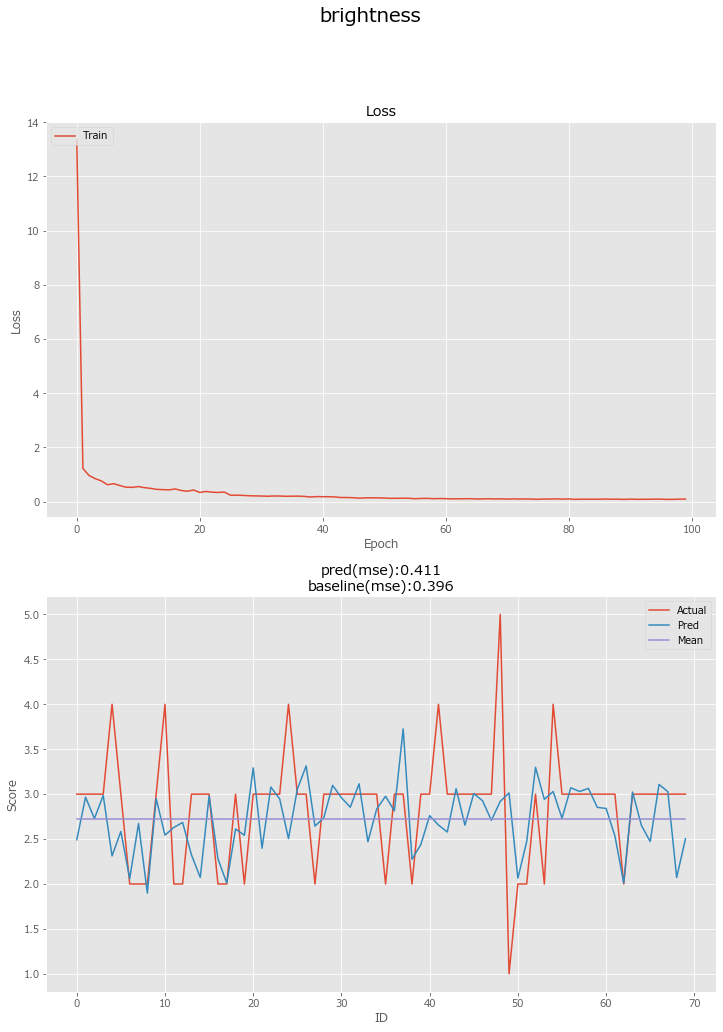

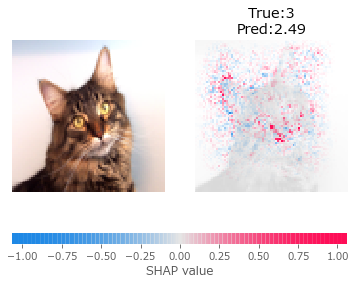

<Figure size 1440x1440 with 0 Axes>

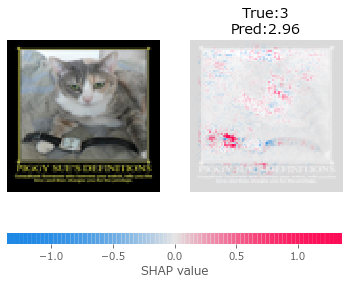

<Figure size 1440x1440 with 0 Axes>

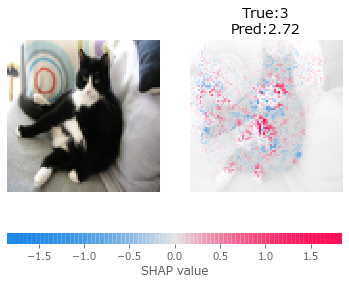

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 76, 76, 32)        2432      
_________________________________________________________________
batch_normalization_59 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 35, 35, 64)        32832     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 7, 7, 64)          0         
__________

<Figure size 1440x1440 with 0 Axes>

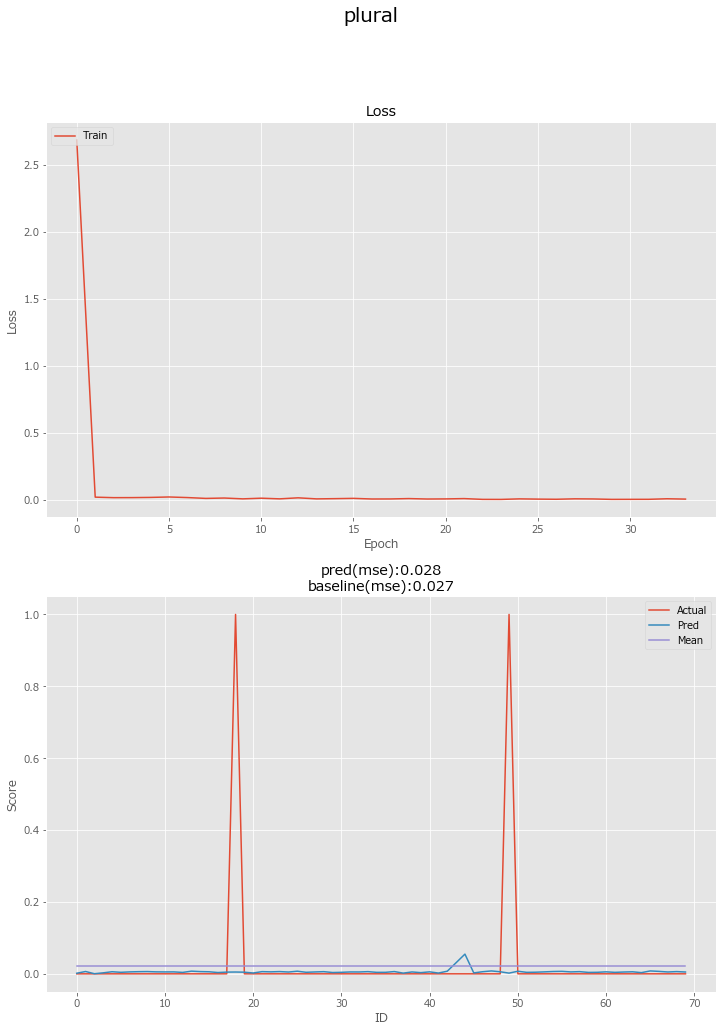

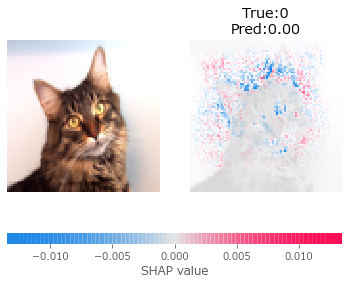

<Figure size 1440x1440 with 0 Axes>

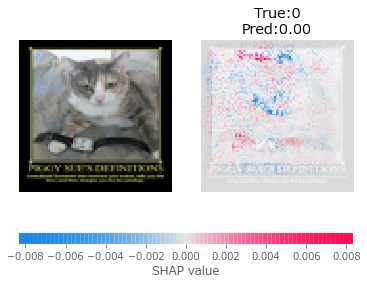

<Figure size 1440x1440 with 0 Axes>

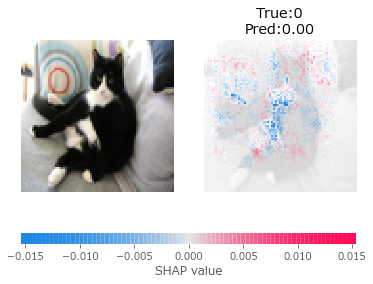

<Figure size 1440x1440 with 0 Axes>

In [196]:
#predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])
pred_list = []
for i,column in enumerate(["front","close","background","focus","cute","position","brightness","plural"]):
    print("============================================================")
    pred_list.append(column_predict(X_train,X_valid,y_train.T[i],y_valid.T[i],column))

## 4, 大モデル作成

In [276]:
X2 = df[["front","close","background","focus","cute","position","brightness","plural"]]
Y2 = df["care"].values

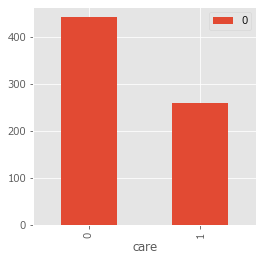

In [277]:
#偏りはsample_weightで調整する予定
pd.DataFrame(df.groupby("care").size()).plot(kind = "bar", figsize = (4, 4))
plt.show()

In [278]:
#最適化される関数
def objective(x,y,trial):
    params={
        "num_leaves":trial.suggest_int("num_leaves",30,400),
        "learning_rate":trial.suggest_uniform("learning_rate",0.1,3.0),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.1,1.0),
        "max_depth":trial.suggest_int("max_depth",3,12),
        "objective":trial.suggest_categorical("objective",["binary"]),
        "random_state":trial.suggest_int("random_state",0,0)
    }
    
    score = 0
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    for train_index,test_index in kf.split(x,y):
        X_train = x.iloc[train_index]
        X_test = x.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        score += accuracy_score(y_test,pred)
    return score    

In [279]:
def last_predict(X,Y,image):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 0,test_size = 0.1)

    evals_result = {}
    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(partial(objective,X_train,y_train),n_trials=200)
    model = lgb.LGBMClassifier(**study.best_params)
    model.fit(X_train, y_train,callbacks=[lgb.record_evaluation(evals_result)])
    pickle.dump(model,open("model/model_lgb.sav","wb"))
    
    #lgbのlossをグラフに出す予定
    #train_metric = evals_result['validation_0']['loss']
    #plt.plot(train_metric, label='train loss')
    #plt.grid()
    #plt.legend()
    #plt.xlabel('rounds')
    #plt.ylabel('logloss')
    #plt.show()
    
    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print("acc:" + str(acc)[:4])
    print()
    print("confusion_matrix:")
    cm = ConfusionMatrix(pred, y_test)
    cm.print_matrix()
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, c="b", label="pred", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()
    
    Xcolumns = X.columns
    features = Xcolumns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    #importance
    plt.figure(figsize=(8,4))
    plt.title("importance")
    plt.barh(range(len(indices)),importances[indices],align="center")
    plt.yticks(range(len(indices)),features[indices])
    plt.show()
    
    #shap
    explainer = shap.TreeExplainer(model,X)    
    for i in range(3):
        print(str(i))
        plt.imshow(image[i])
        plt.show()
        
        shap_values = explainer.shap_values(X.loc[[i]])
        shap.force_plot(explainer.expected_value, 
                    shap_values, 
                    X.loc[[i]], 
                    matplotlib=True,
                    )

[I 2020-04-14 17:23:30,999] Finished trial#0 with value: 3.0462962962962963 with parameters: {'num_leaves': 202, 'learning_rate': 1.8192493928525533, 'feature_fraction': 0.8598391737229156, 'max_depth': 6, 'objective': 'binary', 'random_state': 0}. Best is trial#0 with value: 3.0462962962962963.
[I 2020-04-14 17:23:31,275] Finished trial#1 with value: 3.4074074074074074 with parameters: {'num_leaves': 389, 'learning_rate': 1.3285989180828237, 'feature_fraction': 0.6813047017599905, 'max_depth': 7, 'objective': 'binary', 'random_state': 0}. Best is trial#1 with value: 3.4074074074074074.
[I 2020-04-14 17:23:31,503] Finished trial#2 with value: 2.6574074074074074 with parameters: {'num_leaves': 117, 'learning_rate': 2.6861417022680314, 'feature_fraction': 0.9672964844509263, 'max_depth': 4, 'objective': 'binary', 'random_state': 0}. Best is trial#1 with value: 3.4074074074074074.
[I 2020-04-14 17:23:31,755] Finished trial#3 with value: 2.990740740740741 with parameters: {'num_leaves': 69

[I 2020-04-14 17:23:45,369] Finished trial#54 with value: 3.685185185185185 with parameters: {'num_leaves': 219, 'learning_rate': 0.19233289564079276, 'feature_fraction': 0.2482247408481215, 'max_depth': 11, 'objective': 'binary', 'random_state': 0}. Best is trial#54 with value: 3.685185185185185.
[I 2020-04-14 17:23:45,646] Finished trial#55 with value: 3.4259259259259256 with parameters: {'num_leaves': 377, 'learning_rate': 1.7739629069520861, 'feature_fraction': 0.3141035392370578, 'max_depth': 12, 'objective': 'binary', 'random_state': 0}. Best is trial#54 with value: 3.685185185185185.
[I 2020-04-14 17:23:45,883] Finished trial#56 with value: 2.6851851851851847 with parameters: {'num_leaves': 353, 'learning_rate': 1.8805012723010983, 'feature_fraction': 0.5820695227224625, 'max_depth': 4, 'objective': 'binary', 'random_state': 0}. Best is trial#54 with value: 3.685185185185185.
[I 2020-04-14 17:23:46,151] Finished trial#57 with value: 3.4166666666666665 with parameters: {'num_leav

[I 2020-04-14 17:23:59,858] Finished trial#108 with value: 3.3240740740740744 with parameters: {'num_leaves': 237, 'learning_rate': 1.4723399544425604, 'feature_fraction': 0.6221773951869335, 'max_depth': 3, 'objective': 'binary', 'random_state': 0}. Best is trial#61 with value: 3.6851851851851856.
[I 2020-04-14 17:24:00,102] Finished trial#109 with value: 2.416666666666667 with parameters: {'num_leaves': 91, 'learning_rate': 1.9445770607967099, 'feature_fraction': 0.3160182460417386, 'max_depth': 3, 'objective': 'binary', 'random_state': 0}. Best is trial#61 with value: 3.6851851851851856.
[I 2020-04-14 17:24:00,426] Finished trial#110 with value: 3.462962962962963 with parameters: {'num_leaves': 357, 'learning_rate': 0.7753098661348417, 'feature_fraction': 0.5530846851459573, 'max_depth': 12, 'objective': 'binary', 'random_state': 0}. Best is trial#61 with value: 3.6851851851851856.
[I 2020-04-14 17:24:00,694] Finished trial#111 with value: 3.472222222222222 with parameters: {'num_le

[I 2020-04-14 17:24:14,646] Finished trial#162 with value: 3.2685185185185186 with parameters: {'num_leaves': 125, 'learning_rate': 1.578440870202594, 'feature_fraction': 0.40056838263712824, 'max_depth': 3, 'objective': 'binary', 'random_state': 0}. Best is trial#61 with value: 3.6851851851851856.
[I 2020-04-14 17:24:14,943] Finished trial#163 with value: 3.4814814814814814 with parameters: {'num_leaves': 376, 'learning_rate': 1.2109983854925155, 'feature_fraction': 0.8260023927822497, 'max_depth': 7, 'objective': 'binary', 'random_state': 0}. Best is trial#61 with value: 3.6851851851851856.
[I 2020-04-14 17:24:15,193] Finished trial#164 with value: 3.1388888888888884 with parameters: {'num_leaves': 113, 'learning_rate': 2.4977902195593304, 'feature_fraction': 0.5852064114880949, 'max_depth': 4, 'objective': 'binary', 'random_state': 0}. Best is trial#61 with value: 3.6851851851851856.
[I 2020-04-14 17:24:15,450] Finished trial#165 with value: 3.4814814814814814 with parameters: {'num

acc:0.8166666666666667


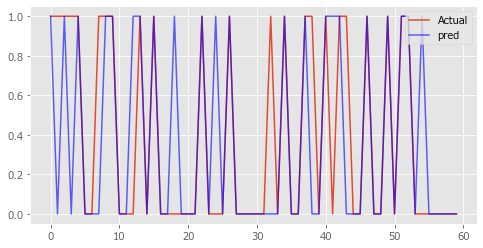

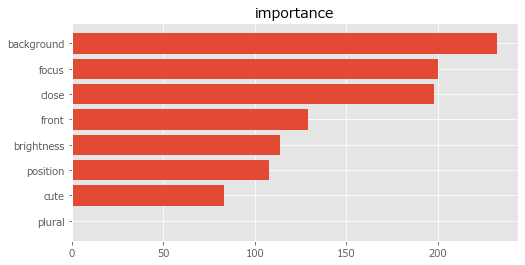

0


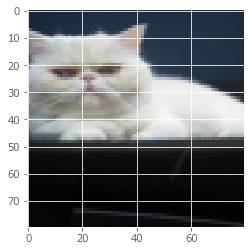

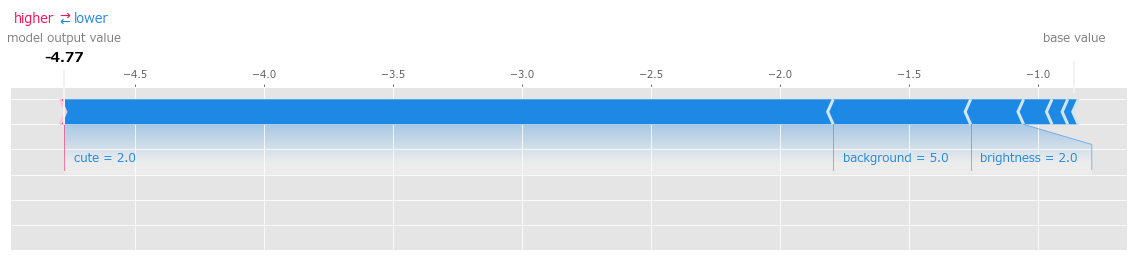

1


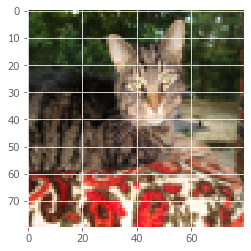

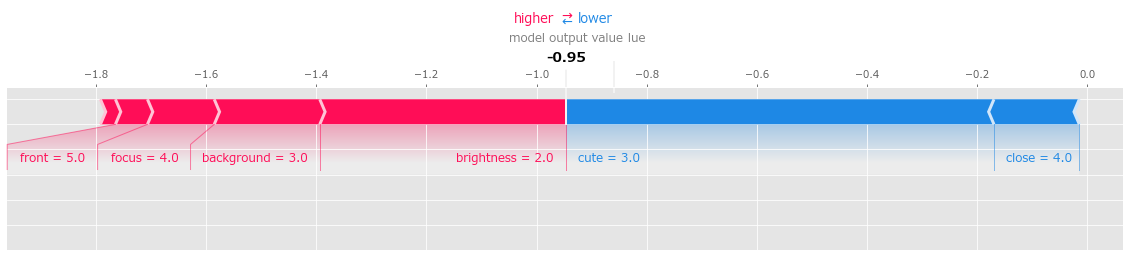

2


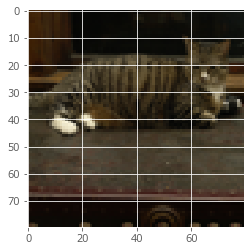

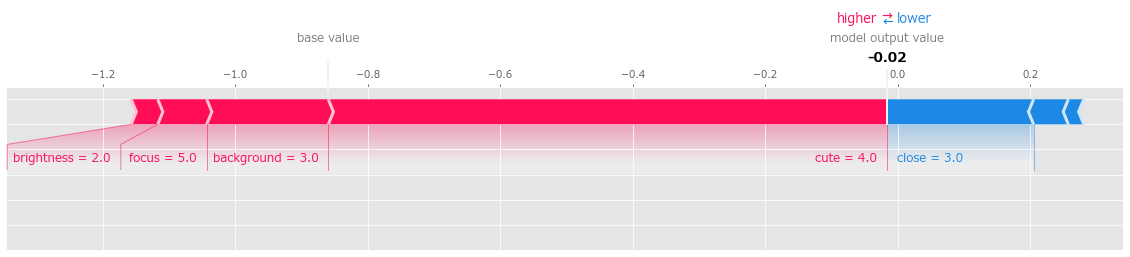

In [75]:
last_predict(X2,Y2,X)

## 5, 保護有無の予想

In [280]:
#小モデルの予想結果を大モデルに投入して保護有無を予想する
model_lgb = pickle.load(open("model/model_lgb.sav","rb"))
X_pred = np.squeeze(np.array(pred_list).T)
pred = model_lgb.predict(X_pred)
#shap値を出す予定
#レーダーチャートを出す予定
print("base_acc:" + str(accuracy_score(np.zeros(len(pred)),np.squeeze(care_valid)))[:4])
print("acc:" + str(accuracy_score(pred,np.squeeze(care_valid)))[:4])
print()
print("confusion_matrix:")
cm = ConfusionMatrix(pred,np.squeeze(care_valid))
cm.print_matrix()

base_acc:0.51
acc:0.57

confusion_matrix:
Predict  0        1        
Actual
0        31       25       

1        5        9        




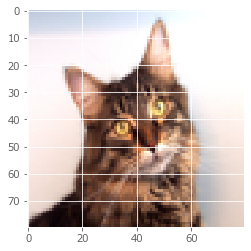

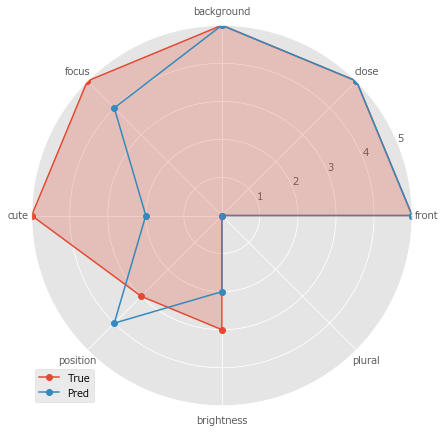

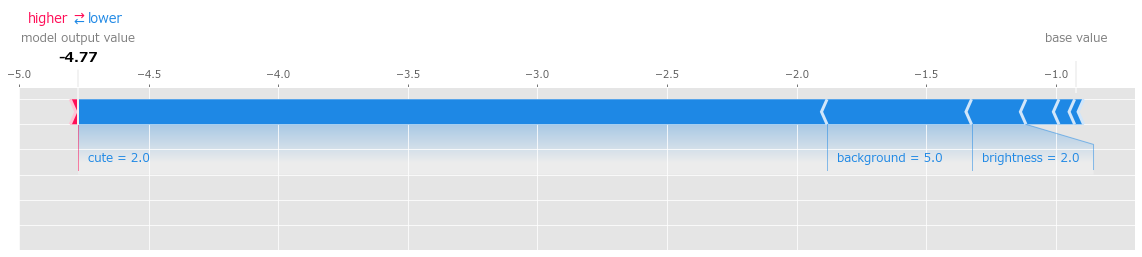

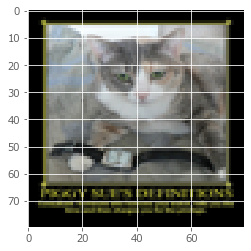

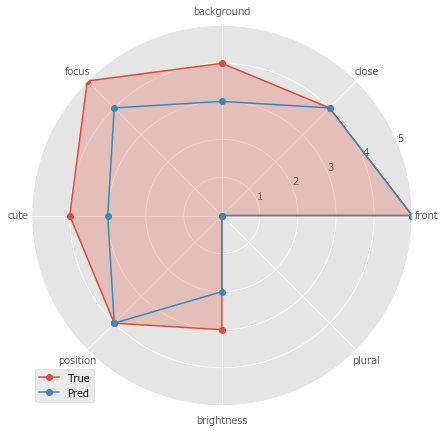

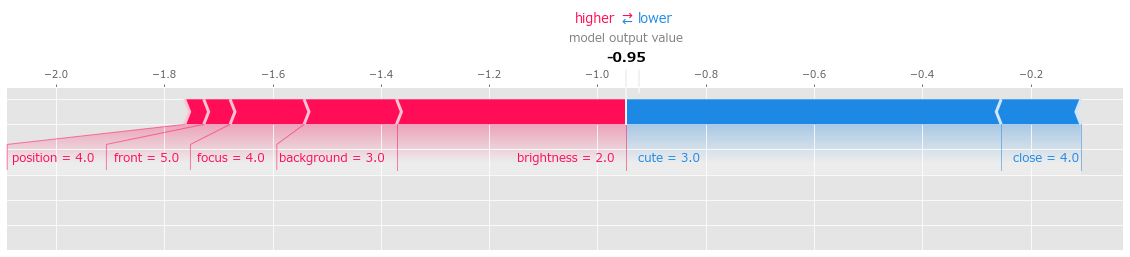

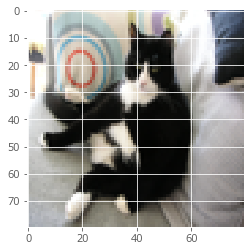

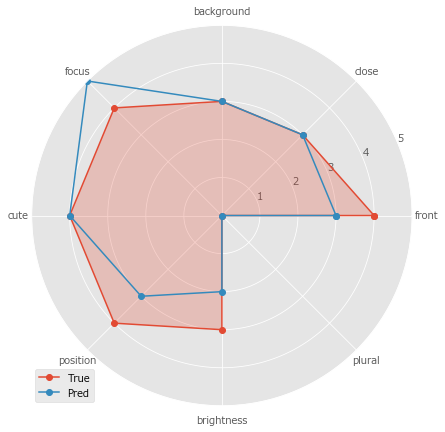

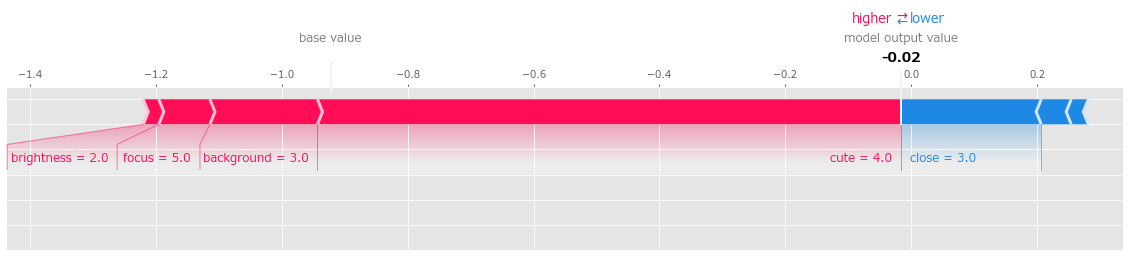

In [281]:
explainer = shap.TreeExplainer(model_lgb,X2)    
for i in range(3):
    plt.imshow(X_valid[i])
    plt.show()
    
    plot_polar(["front","close","background","focus","cute","position","brightness","plural"], y_valid[i], np.squeeze(X2.loc[[i]].values))

    shap_values = explainer.shap_values(X2.loc[[i]])
    shap.force_plot(explainer.expected_value, 
                shap_values, 
                X2.loc[[i]], 
                matplotlib=True,
                )
    print("=======================================")

## 以下考察中

In [120]:
sess = tf.InteractiveSession()

predict_df = pd.DataFrame(index=["MSE_pred","MSE_mean"])

X = np.array(X)

#["front","close","background","focus","cute","position","brightness","plural"]
column = "front"
Y = np.array(df[column])

X = X.astype('float32') / 255
X_train, X_valid, y_train, y_valid = train_test_split(X,Y,random_state = 0,test_size = 0.2)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size,image_size,3)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

hist = model.fit(X_train, y_train, epochs=150, batch_size=20,verbose=1)

Epoch 1/150
480/480 [==============================] - 1s 1ms/step - loss: 3.4678
Epoch 2/150
480/480 [==============================] - 0s 512us/step - loss: 1.4658
Epoch 3/150
480/480 [==============================] - 0s 486us/step - loss: 1.5380
Epoch 4/150
480/480 [==============================] - 0s 486us/step - loss: 1.4372
Epoch 5/150
480/480 [==============================] - 0s 476us/step - loss: 1.4547
Epoch 6/150
480/480 [==============================] - 0s 464us/step - loss: 1.4761
Epoch 7/150
480/480 [==============================] - 0s 479us/step - loss: 1.4452
Epoch 8/150
480/480 [==============================] - 0s 476us/step - loss: 1.4124
Epoch 9/150
480/480 [==============================] - 0s 483us/step - loss: 1.4574
Epoch 10/150
480/480 [==============================] - 0s 492us/step - loss: 1.3618
Epoch 11/150
480/480 [==============================] - 0s 509us/step - loss: 1.5212
Epoch 12/150
480/480 [==============================] - 0s 486us/step - loss

In [109]:
with tf.Session() as sess:
     sess.run(tf.global_variables_initializer())  

In [110]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

[<tf.Tensor 'conv2d_34_input:0' shape=(?, 60, 60, 3) dtype=float32>]

In [121]:
#高速版(未完成)
layer = 8

feed_dict = dict(zip([model.layers[0].input], [X.copy() * 255]))

In [122]:
feed_dict

{<tf.Tensor 'conv2d_38_input:0' shape=(?, 60, 60, 3) dtype=float32>: array([[[[0.09019608, 0.14117648, 0.20392157],
          [0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.17254902, 0.23137255],
          [0.10588235, 0.16862746, 0.22745098]],
 
         [[0.09411765, 0.14509805, 0.20392157],
          [0.09411765, 0.14509805, 0.20784314],
          [0.09411765, 0.14901961, 0.20784314],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.10980392, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         [[0.09803922, 0.15294118, 0.21176471],
          [0.09803922, 0.14901961, 0.21176471],
          [0.09411765, 0.14901961, 0.21176471],
          ...,
          [0.11372549, 0.1764706 , 0.23529412],
          [0.11372549, 0.17254902, 0.23529412],
          [0.10980392, 0.16862746, 0.23137255]],
 
         ...,


In [123]:
temp = K.get_session().run(model.layers[layer].input, feed_dict)

In [124]:
e = shap.DeepExplainer(
    (model.layers[layer].input, model.layers[-1].output),
    temp,
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


AttributeError: 'list' object has no attribute 'shape'

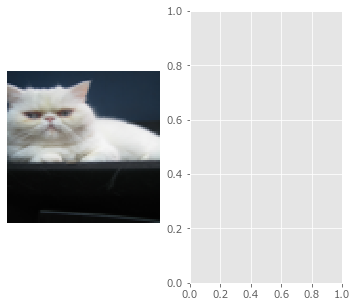

In [12]:
shap_values = e.shap_values(map2layer(X[[0]], 8), ranked_outputs=1)

shap.image_plot(shap_values, X[[0]] * 255, show=False)
plt.gcf().set_size_inches(20, 20)